## 1 Logistic regression

在这部分的练习中，你将建立一个逻辑回归模型来预测一个学生是否能进入大学。假设你是一所大学的行政管理人员，你想根据两门考试的结果，来决定每个申请人是否被录取。你有以前申请人的历史数据，可以将其用作逻辑回归训练集。对于每一个训练样本，你有申请人两次测评的分数以及录取的结果。为了完成这个预测任务，我们准备构建一个可以基于两次测试评分来评估录取可能性的分类模型。

### 1.1 Visualizing the data
在开始实现任何学习算法之前，如果可能的话，最好将数据可视化。

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


让我们创建两个分数的散点图，并使用颜色编码来可视化，如果样本是正的（被接纳）或负的（未被接纳）。

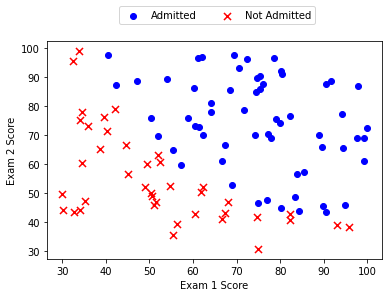

In [4]:
positive = data[data.admitted.isin(['1'])]  # 1
negetive = data[data.admitted.isin(['0'])]  # 0

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(positive['exam1'], positive['exam2'], c='b', label='Admitted')
ax.scatter(negetive['exam1'], negetive['exam2'], s=50, c='r', marker='x', label='Not Admitted')
# 设置图例显示在图的上方
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height* 0.8])
ax.legend(loc='center left', bbox_to_anchor=(0.2, 1.12),ncol=3)
# 设置横纵坐标名
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
plt.show()

看起来在两类间，有一个清晰的决策边界。现在我们需要实现逻辑回归，那样就可以训练一个模型来预测结果。

### 1.2 Sigmoid function

首先来回顾下 logistic回归的假设函数：
$${{h}_{\theta }}\left( x \right)=g(\theta^{T}x)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$$
其中的 g代表一个常用的logistic function为S形函数（Sigmoid function）：
$$g\left( z \right)=\frac{1}{1+e^{-z}}$$

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(- z))

让我们做一个快速的检查，来确保它可以工作。

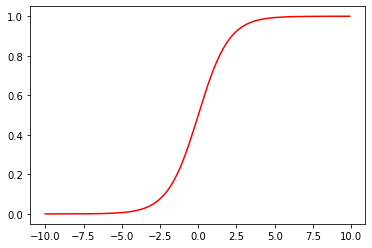

In [6]:
x1 = np.arange(-10, 10, 0.1)
plt.plot(x1, sigmoid(x1), c='r')
plt.show()

感觉很不错~~~

### 1.3 Cost function

$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$$
$${{h}_{\theta }}\left( x \right)=g(\theta^{T}x)$$

In [7]:
def cost(theta, X, y):
    first = (-y) * np.log(sigmoid(X @ theta))
    second = (1 - y)*np.log(1 - sigmoid(X @ theta))
    return np.mean(first - second)  # Returns the average of the array elements. 

现在，我们要做一些设置，获取我们的训练集数据。

In [8]:
# add a ones column - this makes the matrix multiplication work out easier
if 'Ones' not in data.columns:
    data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
X = data.iloc[:, :-1].values  # Convert the frame to its Numpy-array representation.
y = data.iloc[:, -1].values # Return is NOT a Numpy-matrix, rather, a Numpy-array.

theta = np.zeros(X.shape[1])

让我们来检查矩阵的维度，确保一切良好。

In [9]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100,))

In [10]:
cost(theta, X, y)

0.6931471805599453

看起来不错，接下来，我们需要一个函数来计算我们的训练数据、标签和一些参数thate的梯度。

### 1.4 Gradient

* 这是批量梯度下降（batch gradient descent）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [11]:
def gradient(theta, X, y):
    return (X.T @ (sigmoid(X @ theta) - y))/len(X)  
# the gradient of the cost is a vector of the same length as θ where the jth element (for j = 0, 1, . . . , n)

In [12]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

### 1.5 Learning θ parameters

注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算梯度。在练习中，一个称为“fminunc”的Octave函数是用来优化函数来计算成本和梯度参数。由于我们使用Python，我们可以用SciPy的“optimize”命名空间来做同样的事情。

这里我们使用的是高级优化算法，运行速度通常远远超过梯度下降。方便快捷。
只需传入cost函数，已经所求的变量theta，和梯度。cost函数定义变量时变量tehta要放在第一个，若cost函数只返回cost，则设置fprime=gradient。

In [13]:
import scipy.optimize as opt

这里使用fimin_tnc或者minimize方法来拟合，minimize中method可以选择不同的算法来计算，其中包括TNC

In [14]:
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
result
# help(opt.fmin_tnc)

(array([-25.16131855,   0.20623159,   0.20147149]), 36, 0)

最常使用的参数：

func：优化的目标函数

x0：初值

fprime：提供优化函数func的梯度函数，不然优化函数func必须返回函数值和梯度，或者设置approx_grad=True

approx_grad :如果设置为True，会给出近似梯度

args：元组，是传递给优化函数的参数

返回：

x ： 数组，返回的优化问题目标值

nfeval ： 整数，function evaluations的数目

在进行优化的时候，每当目标优化函数被调用一次，就算一个function evaluation。在一次迭代过程中会有多次function evaluation。这个参数不等同于迭代次数，而往往大于迭代次数。

rc ： int,Return code, see below
Return codes are defined as follows:

-1 : Infeasible (lower bound > upper bound)

 0 : Local minimum reached (|pg| ~= 0)
 
 1 : Converged (|f_n-f_(n-1)| ~= 0)
 
 2 : Converged (|x_n-x_(n-1)| ~= 0)
 
 3 : Max. number of function evaluations reached
 
 4 : Linear search failed
 
 5 : All lower bounds are equal to the upper bounds
 
 6 : Unable to progress
 
 7 : User requested end of minimization


下面是第二种方法，结果是一样的

In [15]:
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='TNC', jac=gradient)
res
# help(opt.minimize) 
# res.x  # final_theta

     fun: 0.20349770158947492
     jac: array([9.05849127e-09, 9.04782678e-08, 4.78076698e-07])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 36
     nit: 17
  status: 0
 success: True
       x: array([-25.16131855,   0.20623159,   0.20147149])

调用：

scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

参数：

fun ：优化的目标函数

x0 ：初值，一维数组，shape (n,)(theta)

args ： 元组，可选，额外传递给优化函数的参数(func的除theta外的)

method：求解的算法，选择TNC则和fmin_tnc()类似

jac：返回梯度向量的函数

返回：

返回优化结果对象，x：优化问题的目标数组。success: True表示成功与否，不成功会给出失败信息。

In [16]:
cost(result[0], X, y)

0.20349770158947492

### 1.6 Evaluating logistic regression

学习好了参数θ后，我们来用这个模型预测某个学生是否能被录取。

接下来，我们需要编写一个函数，用我们所学的参数theta来为数据集X输出预测。然后，我们可以使用这个函数来给我们的分类器的训练精度打分。

逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 
当${{h}_{\theta }}$大于等于0.5时，预测 y=1

当${{h}_{\theta }}$小于0.5时，预测 y=0 。

In [17]:
def predict(theta, X):
    probability = sigmoid(X@theta)
    return [1 if x >= 0.5 else 0 for x in probability]  # return a list

In [18]:
final_theta = result[0]
predictions = predict(final_theta, X)
correct = [1 if a==b else 0 for (a, b) in zip(predictions, y)]  # python is amazon
accuracy = sum(correct) / len(X)
accuracy

0.89

可以看到我们预测精度达到了89%，not bad.

也可以用skearn中的方法来检验。

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y))

### 1.6 Decision boundary（决策边界）

$X \times \theta = 0$  (this is the line)

$\theta_0 + x_1\theta_1 + x_2\theta_2=0$

In [19]:
x1 = np.arange(20, 110, step=0.1)
x2 = -(final_theta[0] + x1*final_theta[1]) / final_theta[2]

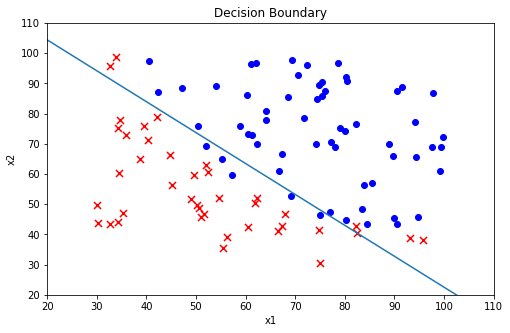

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(positive['exam1'], positive['exam2'], c='b', label='Admitted')
ax.scatter(negetive['exam1'], negetive['exam2'], s=50, c='r', marker='x', label='Not Admitted')
ax.plot(x1, x2)
ax.set_xlim(20, 110)
ax.set_ylim(20, 110)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Decision Boundary')
plt.show()

## 2 Regularized logistic regression

在训练的第二部分，我们将要通过加入正则项提升逻辑回归算法。简而言之，正则化是成本函数中的一个术语，它使算法更倾向于“更简单”的模型（在这种情况下，模型将更小的系数）。这个理论助于减少过拟合，提高模型的泛化能力。这样，我们开始吧。

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

### 2.1 Visualizing the data

In [21]:
data2 = pd.read_csv('ex2data2.txt', names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [22]:
data2.describe()

,Test 1,Test 2,Accepted
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


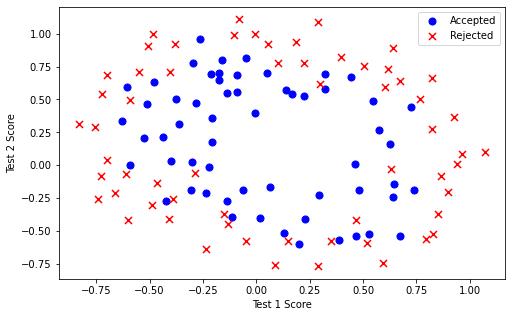

In [23]:
def plot_data():
    positive = data2[data2['Accepted'].isin([1])]
    negative = data2[data2['Accepted'].isin([0])]

    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
    ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
    ax.legend()
    ax.set_xlabel('Test 1 Score')
    ax.set_ylabel('Test 2 Score')
    
plot_data()

注意到其中的正负两类数据并没有线性的决策界限。因此直接用logistic回归在这个数据集上并不能表现良好，因为它只能用来寻找一个线性的决策边界。

所以接下会提到一个新的方法。

### 2.2 Feature mapping

一个拟合数据的更好的方法是从每个数据点创建更多的特征。

我们将把这些特征映射到所有的x1和x2的多项式项上，直到第六次幂。

https://www.zhihu.com/question/65020904
```
for i in 0..power
      for p in 0..i:
        output x1^(i-p) * x2^p```

$${\rm{mapFeature}}(x)=\begin{bmatrix}
{1}\\
{x_1}\\
{x_2}\\
{x_1^2}\\
{x1x2}\\
{x_2^2}\\
{x_1^3}\\
\vdots\\
{x_1x_2^5}\\
{x_2^6}
\end{bmatrix}$$

In [24]:
def feature_mapping(x1, x2, power):
    data = {}
    for i in np.arange(power + 1):
        for p in np.arange(i + 1):
            data["f{}{}".format(i - p, p)] = np.power(x1, i - p) * np.power(x2, p)

#     data = {"f{}{}".format(i - p, p): np.power(x1, i - p) * np.power(x2, p)
#                 for i in np.arange(power + 1)
#                 for p in np.arange(i + 1)
#             }
    return pd.DataFrame(data)

In [25]:
x1 = data2['Test 1'].values
x2 = data2['Test 2'].values

In [26]:
_data2 = feature_mapping(x1, x2, power=6)
_data2.head()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


经过映射，我们将有两个特征的向量转化成了一个28维的向量。

在这个高维特征向量上训练的logistic回归分类器将会有一个更复杂的决策边界，当我们在二维图中绘制时，会出现非线性。

虽然特征映射允许我们构建一个更有表现力的分类器，但它也更容易过拟合。在接下来的练习中，我们将实现正则化的logistic回归来拟合数据，并且可以看到正则化如何帮助解决过拟合的问题。

也可利用 PolynomialFeatures 函数映射多项式特征

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(6)
poly.fit_transform(data2.iloc[:, 0:2].values)

### 2.3 Regularized Cost function

$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

注意：不惩罚第一项$\theta_0$

先获取特征，标签以及参数theta，确保维度良好。

In [27]:
X = _data2.values
y = data2['Accepted'].values
theta = np.zeros(X.shape[1])
X.shape, y.shape, theta.shape

((118, 28), (118,), (28,))

In [28]:
def costReg(theta, X, y, l=1):
    # 不惩罚第一项
    _theta = theta[1: ]
    reg = (l / (2 * len(X))) *(_theta @ _theta)  # _theta@_theta == inner product
    
    return cost(theta, X, y) + reg

In [29]:
costReg(theta, X, y, l=1)

0.6931471805599454

### 2.4 Regularized gradient

因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$

同样不惩罚第一个θ

In [30]:
def gradientReg(theta, X, y, l=1):
    reg = (1 / len(X)) * theta
    reg[0] = 0  
    return gradient(theta, X, y) + reg

In [31]:
gradientReg(theta, X, y, 1)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

### 2.5 Learning parameters

In [34]:
result2 = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(X, y, 1))
result2

(array([ 1.27271026,  0.62529964,  1.18111686, -2.019874  , -0.91743188,
        -1.43166928,  0.12393227, -0.36553118, -0.35725405, -0.17516292,
        -1.45817009, -0.05098418, -0.61558558, -0.27469166, -1.19271299,
        -0.24217841, -0.20603303, -0.04466177, -0.27778948, -0.29539514,
        -0.45645982, -1.04319154,  0.02779373, -0.29244865,  0.01555759,
        -0.32742404, -0.14389149, -0.92467488]),
 32,
 1)

我们还可以使用高级Python库scikit-learn来解决这个问题。

In [153]:
from sklearn import linear_model#调用sklearn的线性回归包
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X, y.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [154]:
model.score(X, y)

0.8305084745762712

### 2.6 Evaluating logistic regression

In [36]:
final_theta = result2[0]
predictions = predict(final_theta, X)
correct = [1 if a==b else 0 for (a, b) in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
accuracy

0.8305084745762712

或者用skearn中的方法来评估结果。

In [156]:
print(classification_report(y, predictions))

             precision    recall  f1-score   support

          0       0.85      0.75      0.80        60
          1       0.77      0.86      0.81        58

avg / total       0.81      0.81      0.80       118



可以看到和skearn中的模型精确度差不多，这很不错。

### 2.7 Decision boundary（决策边界）

$X \times \theta = 0$  (this is the line)

(-1.0, 1.3)

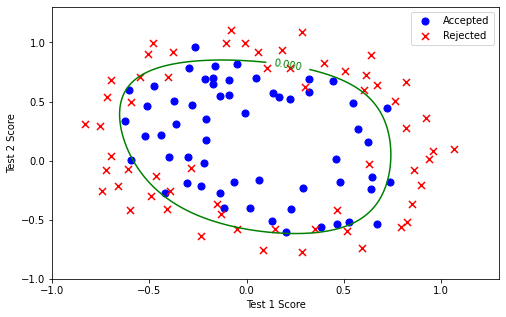

In [67]:
x = np.linspace(-1, 1.5, 250)
xx, yy = np.meshgrid(x, x)

z = feature_mapping(xx.ravel(), yy.ravel(), 6).values
z = z @ final_theta
z = z.reshape(xx.shape)

plot_data()
#plt.contour(xx, yy, z, 0)
CS = plt.contour(xx, yy, z, 0, colors='green')
plt.clabel(CS, fontsize=10)
plt.xlim(-1, 1.3)
plt.ylim(-1, 1.3)